# 2025-01-27 FD Verification

## Last time

* Measuring errors
* Stable discretizations
* FD solution of ODE with Dirichlet boundary conditions (also discussed how to encode Neumann)

## Today
* Finish solving with FD
* Green's functions and eigenfunctions
* Interpolation of the solution (Vandermonde)
* Differentiation of the solution
* Convergence order of differentiation

In [31]:
using Plots
default(linewidth=3)
using LinearAlgebra

## Reading for next time

[Journal of Fluids Engineering: Editorial Policy Statement on the Control of Numerical Accuracy (1986)](https://jedbrown.org/files/RoacheGhiaWhite-JFEEditorialPolicyStatementControlOfNumericalAccuracy-1986.pdf)

# FD solutions - from last time:

* We are solving the Dirichlet BVP (Boundary Value Problem)
\begin{gather} -\frac{d^2 u}{dx^2} = f(x) \quad x \in \Omega = (-1,1) \\
u(-1) = a \quad u(1) = b .
\end{gather}

* Turn this into a linear system by replacing 
    * $x \to [x_1, x_2, \ldots, x_n] = \mathbf{x}$,
    * $u(x) \to [u_1, u_2, \ldots, u_n] = \mathbf{u}$,
    * $f(x) \to [f_1, f_2, \ldots, f_n] = \mathbf{f}$,
    * $\frac{d^2}{dx^2} \to \mathbf{D}^2$.

    
* This yields
 $$ \mathbf{D}^2\mathbf{u} = \mathbf{f}$$

* Encode boundary conditions by replacing first and last rows of $\mathbf{A} = \mathbf{D}^2$:

$$ \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ \\ & & A_{2:n-1,:} & & \\ \\ \\ 0&0 &0 &0 &0 & 1 \end{bmatrix} \begin{bmatrix} u_1 \\ \\ u_{2:} \\ \\ \\ u_n \end{bmatrix} = \begin{bmatrix} a \\ \\ f_{2:} \\ \\ \\ b \end{bmatrix} . $$

* Then linear solve

In [32]:
# Differentiation matrix D and nodes/stencil x

function diff1_mat(x)
    n = length(x)
    D = zeros(n, n)
    h = x[2] - x[1]
    D[1, 1:2] = [-1/h  1/h]
    for i in 2:n-1
        D[i, i-1:i+1] = [-1/2h  0  1/2h]
    end
    D[n, n-1:n] = [-1/h  1/h]
    D
end

n = 12
x = LinRange(-3, 3, n)
diff1_mat(x)

12×12 Matrix{Float64}:
 -1.83333    1.83333    0.0       …   0.0        0.0       0.0
 -0.916667   0.0        0.916667      0.0        0.0       0.0
  0.0       -0.916667   0.0           0.0        0.0       0.0
  0.0        0.0       -0.916667      0.0        0.0       0.0
  0.0        0.0        0.0           0.0        0.0       0.0
  0.0        0.0        0.0       …   0.0        0.0       0.0
  0.0        0.0        0.0           0.0        0.0       0.0
  0.0        0.0        0.0           0.0        0.0       0.0
  0.0        0.0        0.0           0.916667   0.0       0.0
  0.0        0.0        0.0           0.0        0.916667  0.0
  0.0        0.0        0.0       …  -0.916667   0.0       0.916667
  0.0        0.0        0.0           0.0       -1.83333   1.83333

In [33]:
# Laplacian operator (D^2)

function laplacian_dirichlet(x)
    n = length(x)
    D = zeros(n, n)
    h = x[2] - x[1]
    D[1, 1] = 1
    for i in 2:n-1
        D[i, i-1:i+1] = (1/h^2) * [-1, 2, -1]
    end
    D[n, n] = 1
    D
end
laplacian_dirichlet(x)

12×12 Matrix{Float64}:
  1.0       0.0       0.0       0.0      …   0.0       0.0       0.0
 -3.36111   6.72222  -3.36111   0.0          0.0       0.0       0.0
  0.0      -3.36111   6.72222  -3.36111      0.0       0.0       0.0
  0.0       0.0      -3.36111   6.72222      0.0       0.0       0.0
  0.0       0.0       0.0      -3.36111      0.0       0.0       0.0
  0.0       0.0       0.0       0.0      …   0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
  0.0       0.0       0.0       0.0         -3.36111   0.0       0.0
  0.0       0.0       0.0       0.0          6.72222  -3.36111   0.0
  0.0       0.0       0.0       0.0      …  -3.36111   6.72222  -3.36111
  0.0       0.0       0.0       0.0          0.0       0.0       1.0

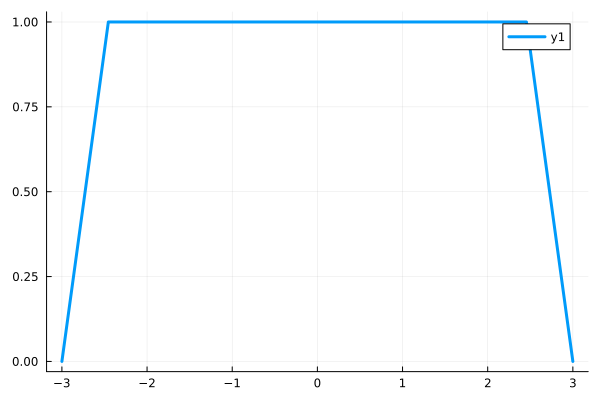

In [34]:
# Left- and right-hand-sides of the equation

L = laplacian_dirichlet(x)
f = one.(x)
f[1] = 0
f[end] = 0;
plot(x, f)

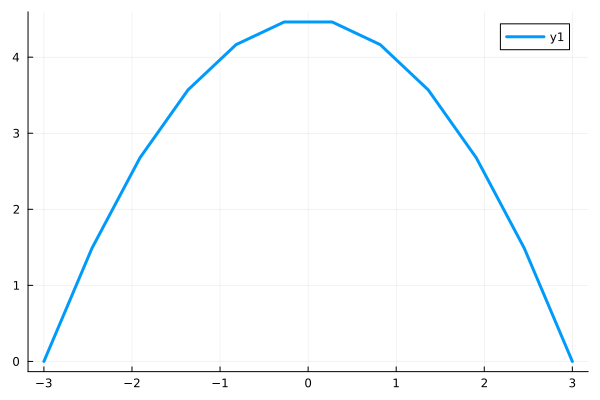

In [35]:
# Linear solve
u = L \ f
plot(x, u)

# Discrete "Green's functions"

* Green's function: impulse response
* If we write the LHS of our equation as a linear differential operator $L$ acting on $u$,

$$ Lu(x) = f(x),$$

then the Green's function $G(x, s)$ ($s$ is for "source") is defined as

$$ LG(x, s) = \delta(x - s) $$

* Motivation: once we have $G(x, s)$, we can "build up" solutions from it for different $f$. Why?

Integrating the definition of the Green's function multiplied by $f(s)$, we get
$$ \int LG(x,s)\,f(s)\,ds=\int \delta (x-s)\,f(s)\,ds=f(x)\, .$$

Due to $L$ only acting on $x$ and being linear, we can bring $L$ out:
$$ L\left(\int G(x,s)\,f(s)\,ds\right)=f(x)\, ,$$

meaning
$$ u(x)=\int G(x,s)\,f(s)\,ds. $$

* Position of the source, $s$, can only be one of the $x_i$ in the linear system
* In matrix form:

$$ LG = I $$

* So $G = L^{-1}$, and the cols of $L^{-1}$ are the "Green's functions" for varying $s$.

In [36]:
x = LinRange(-3, 3, 10)
plot(x, inv(L)[:, 4])

In [37]:
Ln = copy(L)
Ln[n, n-1] = -1
plot(x, inv(Ln)[:, 3])

# Discrete eigenfunctions

* May be of interest instead of the solution itself in e.g. quantum mechanics, or for finding a good basis.

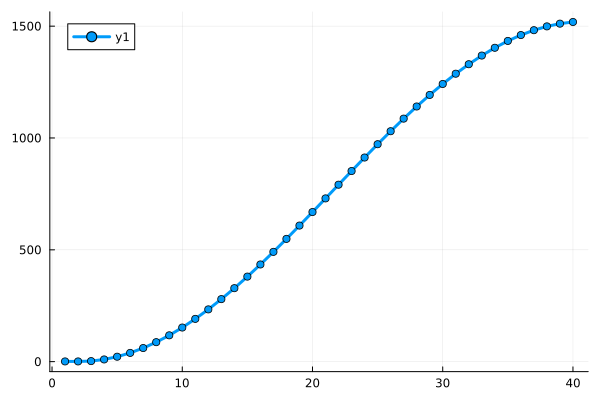

In [38]:
# Eigenvalues of the Laplacian operator (complete with Dirichlet boundary conditions)
x = LinRange(-1, 1, 40)
L = laplacian_dirichlet(x)
Lambda, V = eigen(L)
plot(Lambda, marker=:circle)

Lambda[1:4] = [1.0, 1.0, 2.466067163933257, 9.848275263867125]


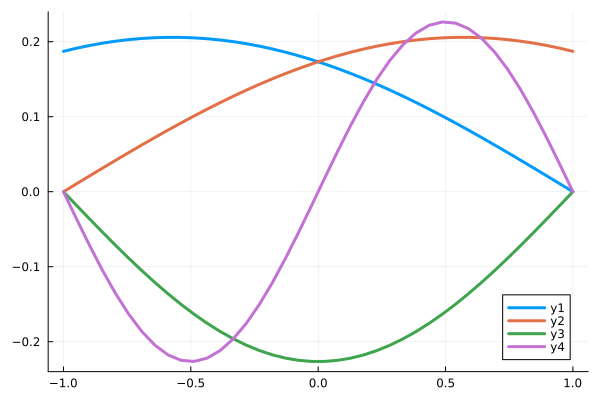

In [39]:
# A few eigenfunctions
@show Lambda[1:4]
plot(x, V[:, 1:4])

# Outlook on our method

## Pros

* Consistent (reminder: if we apply the operator to the exact solution, we get a small residual; it decreases with increasing $n$/decreasing $h$)
* Stable (no "rough" functions, i.e. no nullspace of matrix on the LHS)
* Second order accurate (we hope)

## Cons

* Only second order accurate (at best)
* Worse than second order on non-uniform grids
* Worse than second order at Neumann boundaries
* Boundary conditions break symmetry

# Interpolation by Vandermonde matrices (pair exercise)
 
* Let's say solved the ODE system with a FD difference method. Now we have $\mathbf{u} = [u(x_1), u(x_2), \ldots, u(x_n) ] := [ u_1, u_2, \ldots, u_n]$

* How do we get $u(x)$ from the vector $\mathbf{u}$?

* Try fitting a polynomial that goes through the "data" $u_1$, $u_2$, $\ldots$, of the form

$$ p(x) = c_0 + c_1 x + c_2 x^2 + \dotsb $$


* Exercise: 
    * What degree does the polynomial need to be (how many $c_i$-s) and why?
    * What constraints can we write down for the $c_i$-s?
    * What _linear system_ can we write the constraints as?
    

Solutions: 

* Polynomial needs to be degree $n - 1$ 

* Constraints:

$$ p(x_1) = c_0 + c_1 x_1 + c_2 x_1^2 + \dotsb = u(x_1) $$
$$ p(x_2) = c_0 + c_1 x_2 + c_2 x_2^2 + \dotsb = u(x_2) $$
$$ \vdots $$

* Can write them as a linear system called a **Vandermonde** matrix:

$$ \underbrace{\begin{bmatrix} 1 & x_1 & x_1^2 & \dotsb \\
    1 & x_2 & x_2^2 & \dotsb \\
    1 & x_3 & x_3^2 & \dotsb \\
    \vdots & & & \ddots \end{bmatrix}}_V \begin{bmatrix} c_0 \\ c_1 \\ c_2 \\ \vdots \end{bmatrix} = \begin{bmatrix} u_1 \\ u_2 \\ u_3 \\ \vdots \end{bmatrix} .$$

In [23]:
function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

vander (generic function with 2 methods)

In [21]:
vander(LinRange(-1, 1, 5))

5×5 Matrix{Float64}:
 1.0  -1.0  1.0   -1.0    1.0
 1.0  -0.5  0.25  -0.125  0.0625
 1.0   0.0  0.0    0.0    0.0
 1.0   0.5  0.25   0.125  0.0625
 1.0   1.0  1.0    1.0    1.0

# Fitting a polynomial

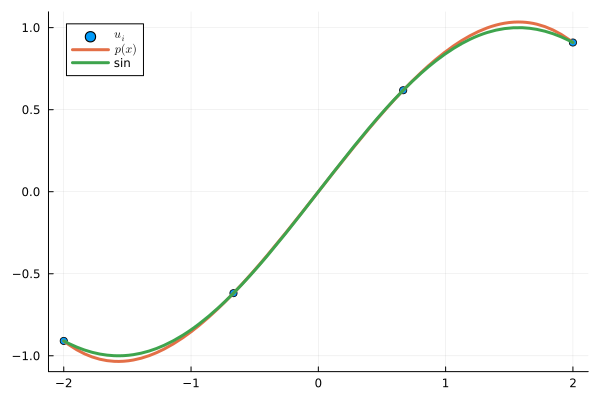

In [24]:
k = 4
x = LinRange(-2, 2, k)
u = sin.(x)
V = vander(x)
c = V \ u
scatter(x, u, label="\$u_i\$", legend=:topleft)
plot!(x -> (vander(x, k) * c)[1,1], label="\$p(x)\$")
plot!(sin, label=sin)

# Differentiating

* We're given the coefficients $c = V^{-1} u$ of the polynomial
$$p(x) = c_0 + c_1 x + c_2 x^2 + \dotsb.$$

* What is
\begin{align} p(0) &= c_0 \\
p'(0) &= c_1 \\ 
p''(0) &= c_2 \cdot 2\\
p^{(k)}(0) &= c_k \cdot k! .
\end{align}

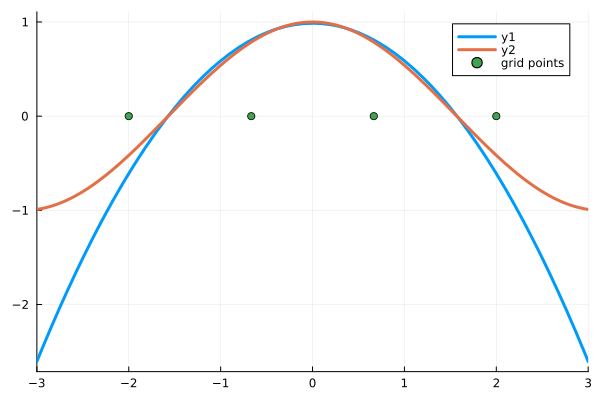

In [29]:
function fdstencil1(source, target)
    "first derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    inv(V)[2, :]' # as a row vector
end
plot([z -> fdstencil1(x, z) * u, cos], xlims=(-3,3))
scatter!(x, 0*x, label="grid points")

# Arbitrary order

In [101]:
function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end
fdstencil(x, 0.5, 2)


1×4 adjoint(::Vector{Float64}) with eltype Float64:
 0.0703125  0.351563  -0.914062  0.492187

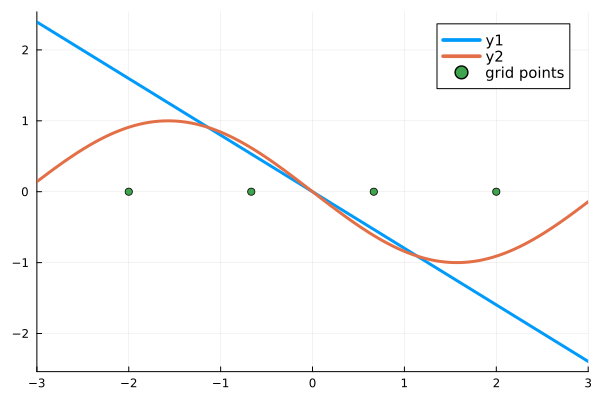

In [102]:
plot([z -> fdstencil(x, z, 2) * u,
        z -> -sin(z)], xlim=(-3, 3)) 
scatter!(x, 0*x, label="grid points")

## We didn't call `inv(V)`; what's up?
$$p(0) = s_0^0 u_0 + s_1^0 u_1 + s_2^0 u_2 + \dotsb = e_0^T \underbrace{V^{-1} u}_c = \underbrace{e_0^T V^{-1}}_{s^0} u$$

# Convergence order (exercise)

* Looking at this convergence graph, deduce the order of convergence for our stencil (for differentiating twice).

In [ ]:
hs = 2 .^ -LinRange(-4, 10, 10)
function diff_error(u, du, h; n, k, z=0)
    x = LinRange(-h, h, n) .+ .5
    fdstencil(x, z, k) * u.(x) - du.(z)
end
errors = [diff_error(sin, t -> -sin(t), h, n=5, k=2, z=.5+0.1*h)
    for h in hs]
plot(hs, abs.(errors), marker=:circle)

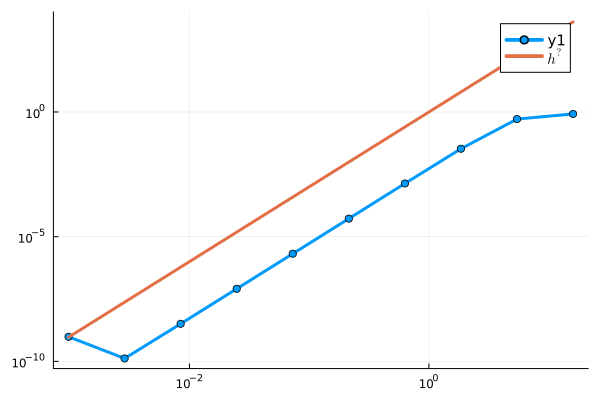

In [26]:
plot!(h -> h^3, label="\$h^?\$", xscale=:log10, yscale=:log10)

## Observations

* When using $n=3$ points, we fit a polynomial of degree 2 and have error $O(h^3)$ for interpolation $p(0)$.
* Each derivative gives up one order of accuracy in general.
* Centered diff on uniform grids can have extra cancellation (superconvergence)
* The Vandermonde matrix is notoriously ill-conditioned with many points $n$. We recommend using a [stable algorithm from Fornberg](https://doi.org/10.1137/S0036144596322507).

* Exercise: what could we have changed about the interpolation method? Hint: there are **two** main degrees of freedom. 

Solution: 
 * We could have changed the representation: $p(x) = c_0 + c_1 x + c_2 x^2 + \ldots$ uses the _monomial basis_ $1, x, x^2, \ldots$, but we could have used a different _basis set_ of functions. This in turn changes what the unknowns $c_0, c_1, \ldots$ represent.
  * We also need to be careful in picking the nodes $x_1, x_2, \ldots$, on which the entries of the Vandermonde matrix explicitly depend.